In [1]:
import os
import wx
app = wx.App()
backend = __import__("Integration")
t1 = backend.turtle_setup()
home = (0,0)

In [2]:
class TabOne(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        
        img = wx.Image(500, 500)
        self.imageCtrl = wx.StaticBitmap(self, wx.ID_ANY, wx.Bitmap(img))
        
class TabTwo(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        self.GCODE = wx.TextCtrl(self, style = wx.TE_READONLY | wx.TE_MULTILINE)
        
        bsizer = wx.BoxSizer()
        bsizer.Add(self.GCODE, 1, wx.EXPAND)
        
        self.SetSizerAndFit(bsizer)

In [3]:
class raterImageDialog(wx.Dialog):

    def __init__(self, *args, **kw):
        super(raterImageDialog, self).__init__(*args, **kw)

        self.InitUI()
        self.SetSize((250, 200))
        self.SetTitle("Rasterized Image Settings")


    def InitUI(self):

        pnl = wx.Panel(self)
        vbox = wx.BoxSizer(wx.VERTICAL)
        self.threshold = wx.TextCtrl(pnl, value = "0.7")
        self.marchSq = wx.RadioButton(pnl, label='Marching Squares (Contour only)',
            style=wx.RB_GROUP)
        self.naive = wx.RadioButton(pnl, label='Naive (Complete Image)')
        
        sb = wx.StaticBox(pnl, label='Algorithm')
        sbs = wx.StaticBoxSizer(sb, orient=wx.VERTICAL)
        sbs.Add(self.marchSq)
        sbs.Add(self.naive)

        hbox1 = wx.BoxSizer(wx.HORIZONTAL)
        hbox1.Add(wx.StaticText(pnl, id = 1, label ="Black Threshold"))
        hbox1.Add(self.threshold, flag=wx.LEFT, border=5)
        sbs.Add(hbox1)

        pnl.SetSizer(sbs)

        hbox2 = wx.BoxSizer(wx.HORIZONTAL)
        okButton = wx.Button(self, wx.ID_OK)
        closeButton = wx.Button(self, label='Close')
        hbox2.Add(okButton)
        hbox2.Add(closeButton, flag=wx.LEFT, border=5)

        vbox.Add(pnl, proportion=1,
            flag=wx.ALL|wx.EXPAND, border=5)
        vbox.Add(hbox2, flag=wx.ALIGN_CENTER|wx.TOP|wx.BOTTOM, border=10)

        self.SetSizer(vbox)

        closeButton.Bind(wx.EVT_BUTTON, self.OnClose)
    
    def OnClose(self, e):
        self.Destroy()


In [4]:
class MainPanel(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        
        subSizer = wx.BoxSizer(wx.VERTICAL)
        grid = wx.GridBagSizer(hgap=5, vgap=5)
        
        self.filepath = wx.TextCtrl(self, value="Filename", size=(500,-1), style = wx.TE_READONLY)

        self.btnOpen =wx.Button(self, label="Open")
        self.Bind(wx.EVT_BUTTON, self.OnOpen, self.btnOpen)
        
        self.btnCalibrate =wx.Button(self, label="Calibrate")
        self.Bind(wx.EVT_BUTTON, self.OnCalibrate, self.btnCalibrate)
        
        self.btnPrint =wx.Button(self, label="Print Image")
        self.Bind(wx.EVT_BUTTON, self.OnPrint, self.btnPrint)
        
        self.btnStop =wx.Button(self, label="Emergency Stop")
        self.Bind(wx.EVT_BUTTON, self.OnStop, self.btnStop)
        self.btnStop.Disable()
        
        self.nb = wx.Notebook(self)
        
        self.tab1 = TabOne(self.nb)
        self.tab2 = TabTwo(self.nb)
        
        self.nb.AddPage(self.tab1, "Image Preview")
        self.nb.AddPage(self.tab2, "GCODE")
        
        grid.Add(self.btnOpen, pos=(0,0))
        grid.Add(self.btnCalibrate, pos=(0,1))
        grid.Add(self.btnPrint, pos=(0,2))
        grid.Add(self.btnStop, pos=(0,4))
        grid.Add(self.filepath, pos=(1,0), span=(0,5))
        grid.Add(self.nb, pos=(2,0), span=(5,5))
        subSizer.Add(grid, 0, wx.ALL, 5)
        self.SetSizerAndFit(subSizer)
        
        self.calibrated = False
        
    def OnOpen(self,e):
        """ Open a file"""
        self.dirname = ''
        self.filename = ''
        self.file_extension = ''
        wildcard = "DXF files (*.dxf)|*.dxf|JPEG and PNG files (*.jpg;*.png)|*.jpg;*.png"
        dlg = wx.FileDialog(self, "Choose a file", self.dirname, "", wildcard, wx.FD_OPEN)
        generated = False
        if dlg.ShowModal() == wx.ID_OK:
            self.filename = dlg.GetFilename()
            self.dirname = dlg.GetDirectory()
            self.path = self.dirname + "\\" + self.filename
            self.filepath.SetValue(self.dirname + "\\" + self.filename)
            self.file_extension = os.path.splitext(self.path)[1]
            
            if self.file_extension.lower() == ".png" or self.file_extension.lower() == ".jpg":
                self.PreviewImage(self, self.path)
                
                dlgRI = raterImageDialog(None)
                res = dlgRI.ShowModal()
                if res == wx.ID_OK:
                    algorithm = dlgRI.naive.GetValue()
                    threshold = float(dlgRI.threshold.GetValue())
                    backend.png_generate_gcode(self.path, threshold, "output.gcode", algorithm)
                    generated = True
                dlgRI.Destroy()
                
            elif self.file_extension.lower() == ".dxf":
                print(self.path)
                self.PreviewDXF(self, self.path)
                backend.dxf_generate_gcode(self.path, "output.gcode")
                generated = True
                
            else:
                print(self.file_extension)
                
            if generated == True:
                self.PreviewGCODE(self)
                
        dlg.Destroy()
        
    def PreviewImage(self, e, path):
        filename, file_extension = os.path.splitext(path)
        img_size = 500
        img = wx.Image(path, wx.BITMAP_TYPE_ANY)
        W = img.GetWidth()
        H = img.GetHeight()
        if W > H:
            NewW = img_size
            NewH = img_size * H / W
        else:
            NewH = img_size
            NewW = img_size * W / H
        img = img.Scale(NewW,NewH)
        self.tab1.imageCtrl.SetBitmap(wx.Bitmap(img))
        self.Refresh()
    
    def PreviewDXF(self, e, path):
        backend.view_dxf(path)
        img_size = 500
        img = wx.Image('Images/Outputs/dxf_output.png', wx.BITMAP_TYPE_ANY)
        W = img.GetWidth()
        H = img.GetHeight()
        if W > H:
            NewW = img_size
            NewH = img_size * H / W
        else:
            NewH = img_size
            NewW = img_size * W / H
        img = img.Scale(NewW,NewH)
        self.tab1.imageCtrl.SetBitmap(wx.Bitmap(img))
        self.Refresh()
        
    def PreviewGCODE(self, e):
        fileGCODE = open("output.gcode", 'r') 
        Lines = fileGCODE.readlines()
        string_lines = ""
        for line in Lines:
            string_lines = string_lines + line
        self.tab2.GCODE.WriteText(string_lines)
        
    def OnCalibrate(self, e):
        dlg = wx.MessageDialog(self, "Are you sure you want to calibrate the simulation home position?",'Calibrate?',wx.YES_NO | wx.ICON_QUESTION)
        result = dlg.ShowModal()
        if result == wx.ID_YES:
            frame = CalibrationWindow(None, "Calibrate")
            parent=wx.GetTopLevelParent(self)
            parent.Show(False)
            frame.SetFocus()
            frame.Raise()
        else:
            print("No pressed")
            
    def OnPrint(self, e):
        t1 = backend.open_sim("Click to close when simulation finishes.")
        self.btnStop.Enable()
        backend.draw_output(t1, "output.gcode", 1)
        
    def OnStop(self, e):
        backend.stop_sim()
        self.btnStop.Disable()

In [5]:
class MainWindow(wx.Frame):

    def __init__(self, parent, title):
        self.dirname=''
        
        self.frame = wx.Frame.__init__(self, parent, title=title, size=(500,-1))
        self.CreateStatusBar()
        panel = MainPanel(self)
        
        filemenu= wx.Menu()
        menuOpen = filemenu.Append(wx.ID_OPEN, "&Open"," Open a file")
        menuAbout = filemenu.Append(wx.ID_ABOUT, "&About"," Information about this program")
        menuExit = filemenu.Append(wx.ID_EXIT,"E&xit"," Terminate the program")
        
        menuBar = wx.MenuBar()
        menuBar.Append(filemenu,"&File")
        self.SetMenuBar(menuBar)
        
        self.Bind(wx.EVT_MENU, self.OnOpen, menuOpen)
        self.Bind(wx.EVT_MENU, self.OnAbout, menuAbout)
        self.Bind(wx.EVT_MENU, self.OnExit, menuExit)
        
        mainSizer = wx.BoxSizer(wx.VERTICAL)
        mainSizer.Add(panel)
        self.SetSizerAndFit(mainSizer)
        self.Show(True)
    
    def OnOpen(self,e):
        self.dirname = ''
        self.filename = ''
        wildcard = "JPEG and PNG files (*.jpg;*.png)|*.jpg;*.png|DXF files (*.dxf)|*.dxf"
        dlg = wx.FileDialog(self, "Choose a file", self.dirname, "", wildcard, wx.FD_OPEN)
        if dlg.ShowModal() == wx.ID_OK:
            self.filename = dlg.GetFilename()
            self.dirname = dlg.GetDirectory()
            self.path = self.dirname + "\\" + self.filename
            self.filepath.SetValue(self.dirname + "\\" + self.filename)
            self.PreviewImage(self, self.path)
        dlg.Destroy()
        
    def OnAbout(self,e):
        dlg = wx.MessageDialog( self, "This program was created as an MSc dissertation. " +
                            "It can convert PNG, JPEG & DXF files into GCODE and then create a 2D print from the GCODE.")
        dlg.ShowModal()
        dlg.Destroy()

    def OnExit(self,e):
        self.Close(True)  # Close the frame.

In [6]:
class CalibrationPanel(wx.Panel):
    def __init__(self, parent):
        self.t1 = backend.open_sim("Calibrate")
        global home
        backend.move_turtle(self.t1, home[0], home[1], 1)
        
        wx.Panel.__init__(self, parent)

        subSizer = wx.BoxSizer(wx.VERTICAL)
        grid = wx.GridBagSizer(hgap=5, vgap=5)
        
        self.lblX = wx.StaticText(self, wx.ID_ANY, label="Home x value:", style=wx.ALIGN_CENTER)
        self.txtXCoord = wx.TextCtrl(self, value=str(home[0]), size=(100,-1))
        
        self.lblY = wx.StaticText(self, wx.ID_ANY, label="Home Y value:", style=wx.ALIGN_CENTER)
        self.txtYCoord = wx.TextCtrl(self, value=str(home[1]), size=(100,-1))
        
        self.btnCalibrate =wx.Button(self, label="Set home")
        self.Bind(wx.EVT_BUTTON, self.OnCalibrate, self.btnCalibrate)
        
        self.btnExit =wx.Button(self, label="Done")
        self.Bind(wx.EVT_BUTTON, self.OnExit, self.btnExit)
        
        grid.Add(self.lblX, pos=(0,0))
        grid.Add(self.txtXCoord, pos=(0,1))
        grid.Add(self.lblY, pos=(0,2))
        grid.Add(self.txtYCoord, pos=(0,3))
        grid.Add(self.btnCalibrate, pos=(1,1))
        grid.Add(self.btnExit, pos=(1,3))
        subSizer.Add(grid, 0, wx.ALL, 5)
        self.SetSizerAndFit(subSizer)
        
        
    def OnCalibrate(self,e):
        xCoord = int(self.txtXCoord.GetValue())
        yCoord = int(self.txtYCoord.GetValue())
        backend.calibrate_sim(self.t1, xCoord, yCoord)
        global home
        home = (xCoord,yCoord)
        
    def OnExit(self,e):
        dlg = wx.MessageDialog(self, "Any changes since confirming calibration by pressing 'Set Home' will be lost. \n" + 
                               "Are you sure you're done calibrating the simulation home position?",
                               'Calibrated?',wx.YES_NO | wx.ICON_QUESTION)
        result = dlg.ShowModal()
        if result == wx.ID_YES:
            backend.close_sim(self.t1)
            mainFrame.Show(True)
            parent=wx.GetTopLevelParent(self)
            parent.Close(True)  # Close the frame.
        else:
            print("No pressed")

In [7]:
class CalibrationWindow(wx.Frame):

    def __init__(self, parent, title):
        self.dirname=''
        
        self.frame = wx.Frame.__init__(self, parent, title=title, size=(500,-1), style=wx.CAPTION)
        self.CreateStatusBar()
        panel = CalibrationPanel(self)
        
        mainSizer = wx.BoxSizer(wx.VERTICAL)
        mainSizer.Add(panel)
        self.SetSizerAndFit(mainSizer)
        self.Show(True)

C:\Users\Arran\Diss\Pen_plotter\Project\Python\DXF\Frame.dxf
G00 X420 Y711
G01 X417 Y712
G00 X423 Y711
G01 X422 Y712
G00 X422 Y712
G01 X420 Y711
G00 X539 Y711
G01 X541 Y712
G00 X422 Y710
G01 X420 Y711
G00 X422 Y710
G01 X423 Y711
G00 X303 Y686
G01 X322.1 Y691.7
G00 X322.1 Y691.7
G01 X333.846 Y696.231
G00 X333.846 Y696.231
G01 X339 Y700
G00 X339 Y700
G01 X341 Y705
G00 X341 Y705
G01 X339.75 Y707.75
G00 X339.75 Y707.75
G01 X332.077 Y706.615
G00 X332.077 Y706.615
G01 X328.9 Y705.2
G00 X328.9 Y705.2
G01 X300 Y689
G00 X300 Y689
G01 X298 Y687
G00 X298 Y687
G01 X299 Y686
G00 X299 Y686
G01 X303 Y686
G00 X289 Y678
G01 X290.846 Y679.231
G00 X290.846 Y679.231
G01 X295 Y682
G00 X295 Y682
G01 X295 Y684
G00 X295 Y684
G01 X294 Y685
G00 X294 Y685
G01 X291.9 Y684.2
G00 X291.9 Y684.2
G01 X291.1 Y683.8
G00 X291.1 Y683.8
G01 X288 Y682
G00 X288 Y682
G01 X288 Y679
G00 X288 Y679
G01 X289 Y678
G00 X459 Y675
G01 X461 Y676
G00 X461 Y676
G01 X463 Y678
G00 X463 Y678
G01 X463 Y679
G00 X463 Y679
G01 X460 Y682
G00 X46

G00 X288 Y189
G01 X283 Y188
G00 X283 Y188
G01 X281 Y186
G00 X281 Y186
G01 X284 Y182
G00 X284 Y182
G01 X287 Y180
G00 X673 Y178
G01 X691 Y194
G00 X691 Y194
G01 X691.246 Y194.795
G00 X691.246 Y194.795
G01 X699 Y204
G00 X699 Y204
G01 X699 Y208
G00 X699 Y208
G01 X693 Y212
G00 X693 Y212
G01 X691 Y212
G00 X691 Y212
G01 X677 Y202
G00 X677 Y202
G01 X664 Y187
G00 X664 Y187
G01 X664 Y186
G00 X664 Y186
G01 X669 Y184
G00 X669 Y184
G01 X673 Y178
G00 X300 Y168
G01 X303 Y170
G00 X303 Y170
G01 X305 Y180
G00 X305 Y180
G01 X303 Y183
G00 X303 Y183
G01 X297.8 Y177.1
G00 X297.8 Y177.1
G01 X296.2 Y173.9
G00 X296.2 Y173.9
G01 X295 Y171
G00 X295 Y171
G01 X299.1 Y168.2
G00 X299.1 Y168.2
G01 X300 Y168
G00 X649 Y159
G01 X652.1 Y160.8
G00 X652.1 Y160.8
G01 X657 Y163
G00 X657 Y163
G01 X665 Y172
G00 X665 Y172
G01 X665 Y175
G00 X665 Y175
G01 X659 Y183
G00 X659 Y183
G01 X657.1 Y181.8
G00 X657.1 Y181.8
G01 X653 Y179
G00 X653 Y179
G01 X652.8 Y178.1
G00 X652.8 Y178.1
G01 X652 Y177
G00 X652 Y177
G01 X655.088 Y175.353
G00 

C:\Users\Arran\Diss\Pen_plotter\Project\Python\DXF\circle.dxf
G00 X0 Y-0.02
G03 R 0.02 X0.0 Y-0.02 S-90 E90
G03 R 0.02 X0.0 Y0.02 S90 E270
C:\Users\Arran\Diss\Pen_plotter\Project\Python\DXF\Frame.dxf
G00 X420 Y711
G01 X417 Y712
G00 X423 Y711
G01 X422 Y712
G00 X422 Y712
G01 X420 Y711
G00 X539 Y711
G01 X541 Y712
G00 X422 Y710
G01 X420 Y711
G00 X422 Y710
G01 X423 Y711
G00 X303 Y686
G01 X322.1 Y691.7
G00 X322.1 Y691.7
G01 X333.846 Y696.231
G00 X333.846 Y696.231
G01 X339 Y700
G00 X339 Y700
G01 X341 Y705
G00 X341 Y705
G01 X339.75 Y707.75
G00 X339.75 Y707.75
G01 X332.077 Y706.615
G00 X332.077 Y706.615
G01 X328.9 Y705.2
G00 X328.9 Y705.2
G01 X300 Y689
G00 X300 Y689
G01 X298 Y687
G00 X298 Y687
G01 X299 Y686
G00 X299 Y686
G01 X303 Y686
G00 X289 Y678
G01 X290.846 Y679.231
G00 X290.846 Y679.231
G01 X295 Y682
G00 X295 Y682
G01 X295 Y684
G00 X295 Y684
G01 X294 Y685
G00 X294 Y685
G01 X291.9 Y684.2
G00 X291.9 Y684.2
G01 X291.1 Y683.8
G00 X291.1 Y683.8
G01 X288 Y682
G00 X288 Y682
G01 X288 Y679
G00 X288

G01 X219 Y271
G00 X219 Y271
G01 X223 Y261
G00 X737 Y261
G01 X739.7 Y265.1
G00 X739.7 Y265.1
G01 X742 Y271
G00 X742 Y271
G01 X741 Y272
G00 X741 Y272
G01 X739 Y271
G00 X739 Y271
G01 X734 Y271
G00 X734 Y271
G01 X731 Y275
G00 X731 Y275
G01 X727.2 Y268.9
G00 X727.2 Y268.9
G01 X726 Y266
G00 X726 Y266
G01 X727 Y265
G00 X727 Y265
G01 X734 Y265
G00 X734 Y265
G01 X736.2 Y262.1
G00 X736.2 Y262.1
G01 X737 Y261
G00 X232 Y249
G01 X239 Y253
G00 X239 Y253
G01 X241 Y257
G00 X241 Y257
G01 X239.2 Y261.1
G00 X239.2 Y261.1
G01 X236 Y265
G00 X236 Y265
G01 X235 Y264
G00 X235 Y264
G01 X234.647 Y261.088
G00 X234.647 Y261.088
G01 X233.75 Y258.25
G00 X233.75 Y258.25
G01 X231 Y257
G00 X231 Y257
G01 X229 Y257
G00 X229 Y257
G01 X228 Y258
G00 X228 Y258
G01 X226 Y258
G00 X226 Y258
G01 X225 Y257
G00 X225 Y257
G01 X226.8 Y252.9
G00 X226.8 Y252.9
G01 X227 Y252
G00 X227 Y252
G01 X230.9 Y249.8
G00 X230.9 Y249.8
G01 X232 Y249
G00 X730 Y247
G01 X732.2 Y249.9
G00 X732.2 Y249.9
G01 X736 Y257
G00 X736 Y257
G01 X734 Y259
G00 X7

C:\Users\Arran\Diss\Pen_plotter\Project\Python\DXF\knot_005.DXF
G00 X2.985 Y5.501
G01 X3.13 Y5.646
G00 X2.89 Y6.706
G01 X2.89 Y5.731
G00 X3.095 Y6.501
G01 X3.095 Y5.731
G00 X2.89 Y6.706
G01 X3.813 Y6.706
G00 X3.095 Y6.501
G01 X3.813 Y6.501
G00 X3.21 Y6.386
G01 X3.528 Y6.386
G00 X3.415 Y6.181
G01 X3.528 Y6.181
G00 X3.21 Y6.386
G01 X3.21 Y6.086
G00 X3.415 Y6.181
G01 X3.415 Y6.086
G00 X4.381 Y6.706
G01 X4.453 Y6.706
G00 X4.381 Y6.501
G01 X4.453 Y6.501
G00 X4.814 Y6.147
G01 X4.814 Y6.061
G00 X5.02 Y6.147
G01 X5.02 Y5.856
G00 X4.677 Y6.061
G01 X4.814 Y6.061
G00 X4.677 Y5.856
G01 X5.02 Y5.856
G00 X2.89 Y5.187
G01 X2.89 Y5.091
G00 X3.095 Y5.187
G01 X3.095 Y5.091
G00 X4.736 Y5.746
G01 X4.808 Y5.746
G00 X4.736 Y5.541
G01 X4.808 Y5.541
G00 X5.021 Y6.706
G01 X5.093 Y6.706
G00 X5.021 Y6.501
G01 X5.093 Y6.501
G00 X5.13 Y6.182
G01 X5.13 Y5.856
G00 X5.335 Y6.182
G01 X5.335 Y6.061
G00 X5.376 Y5.746
G01 X5.448 Y5.746
G00 X5.376 Y5.541
G01 X5.448 Y5.541
G00 X5.661 Y6.706
G01 X5.733 Y6.706
G00 X5.661 Y6.

0

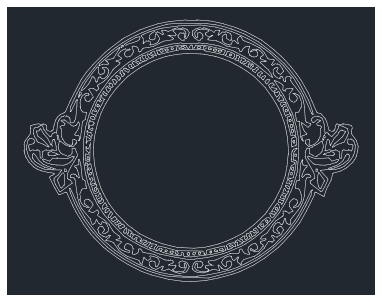

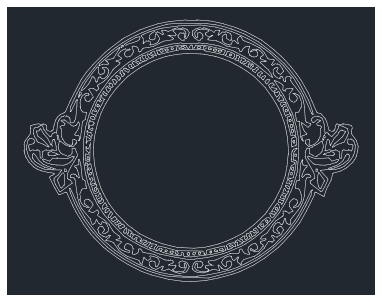

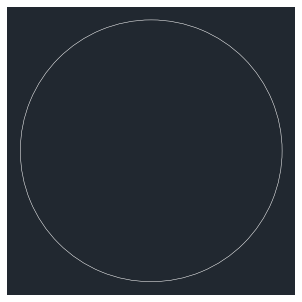

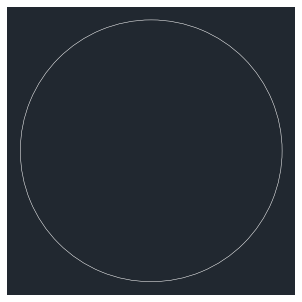

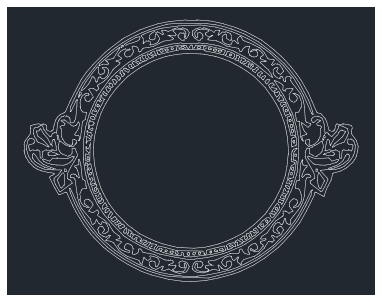

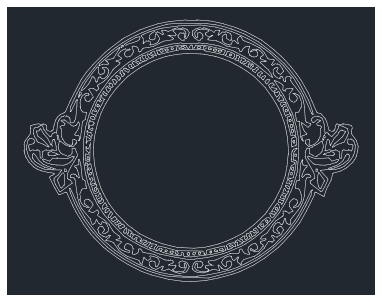

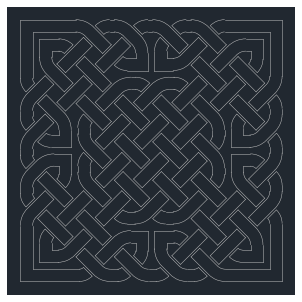

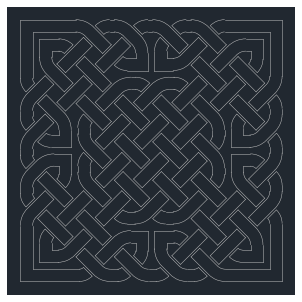

In [8]:
mainFrame = MainWindow(None, "2D Plotter")
mainFrame.CenterOnScreen()
mainFrame.SetFocus()
mainFrame.Raise()
app.MainLoop()